In [1]:
import h5py
import numpy as np
from sklearn.metrics import mean_absolute_error
import pandas as pd
from disaggregate.im2seq_clean import Im2Seq
from disaggregate.batchgenerator import BatchGenerator 
import matplotlib.pyplot as plt

In [2]:
applianceToTrain = "dishwasher"

In [3]:
def load_data_for_im2seq(h5_path, appliance, building='building2', max_ratio=0.3):
    with h5py.File(h5_path, 'r') as f:
        mains = f[f'{building}/mains/power/active'][:]
        target = f[f'{building}/{appliance}/power/active'][:]

    # Trim to same length
    min_len = min(len(mains), len(target))
    mains = mains[:min_len]
    target = target[:min_len]

    # Optionally truncate for quick testing
    if max_ratio < 1.0:
        trim_len = int(min_len * max_ratio)
        mains = mains[:trim_len]
        target = target[:trim_len]

    # Return as single-column DataFrames (expected by Im2Seq)
    return pd.DataFrame(mains, columns=['mains']), pd.DataFrame(target, columns=[appliance])

In [4]:
# Load raw data
mains_df, appliance_df = load_data_for_im2seq('./data/REFIT_House2.h5', appliance=applianceToTrain, max_ratio=0.5)

# Downsample for fast training
mains_df = mains_df[:int(0.25 * len(mains_df))]
appliance_df = appliance_df[:int(0.25 * len(appliance_df))]

# Set the fraction for training
train_frac = 0.8

split_idx = int(len(mains_df) * train_frac)

# Time-based split
mains_train = mains_df[:split_idx]
mains_test  = mains_df[split_idx:]

appliance_train = appliance_df[:split_idx]
appliance_test  = appliance_df[split_idx:]

print("Train shape:", mains_train.shape, appliance_train.shape)
print("Test shape:", mains_test.shape, appliance_test.shape)


Train shape: (573352, 1) (573352, 1)
Test shape: (143338, 1) (143338, 1)


In [ ]:
# Create and train model
model = Im2Seq({
    'sequence_length': 200,
    'img_size': 200,
    'img_method': 'gasf',         # 'mtf' 'gasf', 'rp'
    'n_epochs': 10,
    'batch_size': 100,
})

model.models[applianceToTrain] = model.return_network()
model.appliance_params = {
    applianceToTrain: {
        'mean': appliance_train[applianceToTrain].mean(),
        'std': appliance_train[applianceToTrain].std()
    }
}

model.partial_fit(
    [mains_train],                          # shape: (N, 1)
    [(applianceToTrain, [appliance_train])]         # shape: (N, 1)
)

Training Im2Seq model with method: gasf
train_main shape: (573353, 200), power shape: (573353, 200)
Training dishwasher...
Starting model.fit for dishwasher, epochs=10
Steps per epoch: 4873
Epoch 1/10
4873/4873 [==============================] - 1423s 292ms/step - loss: 0.7962 - val_loss: 0.7383
Epoch 2/10
4873/4873 [==============================] - 1347s 276ms/step - loss: 0.7025 - val_loss: 0.6762
Epoch 3/10
4873/4873 [==============================] - 1342s 275ms/step - loss: 0.6450 - val_loss: 0.6214
Epoch 4/10
4873/4873 [==============================] - 1656s 340ms/step - loss: 0.5928 - val_loss: 0.5805
Epoch 5/10
1894/4873 [==========>...................] - ETA: 26:25 - loss: 0.5594

In [ ]:
appliance = applianceToTrain
L = model.sequence_length
half = L // 2

# 1) Preprocess mains (test mode uses the training mains_mean/std)
processed_mains_lst = model.call_preprocessing([mains_test], [], method='test')
# single item list
X_windows = processed_mains_lst[0].values    # shape: (N, L)

# 2) Make image batches with BatchGenerator, but collect X arrays explicitly
dummy_y = np.zeros((len(X_windows), L), dtype=np.float32)   # not used
bg = BatchGenerator(X_windows, dummy_y, model.batch_size, model.img_method, model.img_size)

X_img_batches = []
for i in range(len(bg)):
    Xb, _ = bg[i]          # ignore y
    X_img_batches.append(Xb)

X_imgs = np.concatenate(X_img_batches, axis=0)  # shape: (N, img_size, img_size, 1)

# 3) Predict window-wise for this appliance
net = model.models[appliance]
yhat_windows = net.predict(X_imgs, batch_size=model.batch_size, verbose=0)  # (N, L, 1) or (N, L)

yhat_windows = yhat_windows.reshape(len(yhat_windows), L)

# 4) Overlap-add and average
n = len(yhat_windows) + L - 1
sum_arr    = np.zeros(n, dtype=np.float32)
counts_arr = np.zeros(n, dtype=np.float32)

for i in range(len(yhat_windows)):
    sum_arr[i:i+L]    += yhat_windows[i]
    counts_arr[i:i+L] += 1.0

avg_arr = np.divide(sum_arr, counts_arr, out=np.zeros_like(sum_arr), where=counts_arr != 0)

# 5) De-normalize with appliance stats and clip to nonnegative
mu  = model.appliance_params[appliance]['mean']
std = model.appliance_params[appliance]['std']
pred_full = np.clip(mu + avg_arr * std, 0, None)   # length n = N + L - 1

# 6) Trim borders (drop half-window on both ends) to recover N samples
pred_trimmed = pred_full[half: n-half]              # length N == len(mains_test)

# 7) Align ground truth and evaluate
true_vals = appliance_test[appliance].values[:len(pred_trimmed)]
mae = mean_absolute_error(true_vals, pred_trimmed)
print(f"Test MAE ({appliance}): {mae:.3f}")


Test MAE (dishwasher): 138.131


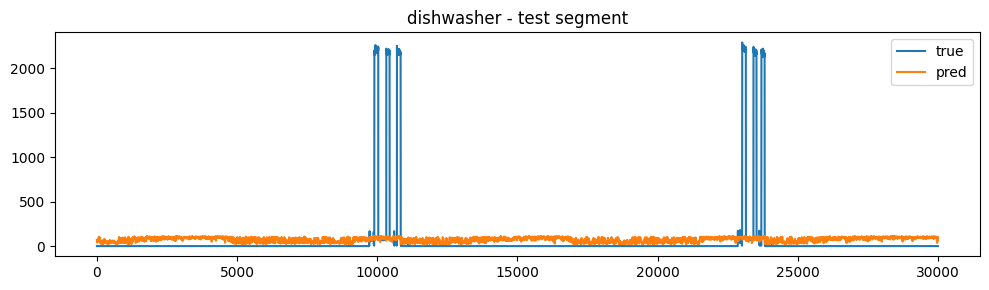

In [ ]:
seg = slice(0, min(30000, len(pred_trimmed)))
plt.figure(figsize=(10,3))
plt.plot(true_vals[seg], label='true')
plt.plot(pred_trimmed[seg], label='pred')
plt.legend(); plt.title(f'{appliance} - test segment')
plt.tight_layout(); plt.show()